In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn.init as init
from torchdiffeq import odeint_adjoint

In [3]:
torch.cuda.empty_cache()

In [4]:
# Ode for learn micro state to macro state
class Ode_Feature(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Ode_Feature, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # model
        self.linear1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.linear4 = nn.Linear(self.input_dim, self.hidden_dim)
        self.linear5 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear6 = nn.Linear(self.hidden_dim, self.input_dim)
        # self.linear7 = nn.Linear(self.hidden_dim, self.input_dim)
        self.relu = nn.ReLU(inplace=True)

    # forward
    def forward(self, t, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.linear6(out)
        # out = self.relu(out)
        # out = self.linear7(out)
        return out
    
class Ode_Coder(nn.Module):
    # Ode_Coder for encoder and decoder
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(Ode_Coder, self).__init__()
        self.odefunc = odefunc
        self.forward_time = torch.tensor([0, 0.1]).float()
        self.inverse_time = torch.tensor([0.1, 0]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x):
        self.forward_time = self.forward_time.type_as(x)
        out = odeint_adjoint(self.odefunc, x, t=self.forward_time, rtol=self.rtol, atol=self.atol)
        return out[1]
    
    def inverse(self, x):
        self.inverse_time = self.inverse_time.type_as(x)
        out = odeint_adjoint(self.odefunc, x, t=self.inverse_time, rtol=self.rtol, atol=self.atol)
        return out[1]

# Neural ODE Learner
class OdeFunc(nn.Module):
# Structure
    def __init__(self, dim_input, dim_hidden):
        super(OdeFunc, self).__init__()

        self.linear1 = nn.Linear(dim_input, dim_hidden)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(dim_hidden, dim_hidden)
        self.linear3 = nn.Linear(dim_hidden, dim_input)

# Forward
    def forward(self, t, x):
        # print("x_ode is finite", torch.isfinite(x).all())
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        # print("out is finite", torch.isfinite(out).all())
        return out
    
class OdeSolver(nn.Module):
# Solver
# rtol, atol maybe need proper numbers
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(OdeSolver, self).__init__()
        self.odefunc = odefunc
        self.forward_time = torch.tensor([0, 0.1]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x):
        self.forward_time = self.forward_time.type_as(x)
        out = odeint_adjoint(self.odefunc, x, self.forward_time, rtol=self.rtol, atol=self.atol)

        return out[1]

class Ode_NIS(nn.Module):
    def __init__(self, input_dim, hidden_dim, scale):
        # Initialize
        super(Ode_NIS, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.scale = scale
        # Coder
        self.Coder = Ode_Coder(Ode_Feature(self.input_dim, self.hidden_dim))
        self.Solver = OdeSolver(OdeFunc(self.input_dim, self.hidden_dim))

    def forward(self, x):
        # Encoding
        y = self.Coder.forward(x)
        # drop dimensions
        mask_d = torch.cat((torch.zeros(1, self.input_dim-self.scale), torch.ones(1, self.scale)), -1).to(x.device)
        y = y*mask_d
        # ODESolver
        self.Solver = self.Solver.to(x.device)
        y_out = self.Solver(y)
        # make sure the dimensions are dropped
        y_out = mask_d*y_out
        # add Gaussian Noise
        g_noise = torch.cat((torch.normal(0, 1, size=(1, self.input_dim-self.scale)),
                             torch.zeros(1, self.scale)), -1).to(x.device)
        y_out = y_out + g_noise
        # Decoding
        x_out = self.Coder.inverse(y_out)

        return x_out, y, y_out


In [5]:
def fit(epochs, model, opt, train_dl):
    num_batches = len(train_dl)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    Loss_Func = nn.MSELoss()
    epoch = 0
    # training
    for epoch in range(epochs):
        batch_count = 0
        print(f"Train epoch{epoch+1}")
        # set model to training mode
        model.train()
        for x, y in train_dl:
            batch_count+=1
            x = x.to(device)
            y = y.to(device)
            # loss calculation
            pred_y,_,_ = model(x.float())
            loss = Loss_Func(pred_y, y.float())
            # backward
            loss.backward()
            opt.step()
            opt.zero_grad()
            if batch_count % int(0.25*num_batches) == 0:
                print('[{}/{}], loss_Norm = {:.4f}'.format(batch_count, num_batches, loss))

            del x, y, pred_y, loss
        epoch += 1

In [6]:
from scipy.integrate import odeint

In [7]:
# Spring Oscillator equation
# dz/dt = v;  dv/dt = −z

def SOE(x, t):
    z1, v1, z2, v2 = x
    dxdt = [v1, -z1, v2, -z2]
    return dxdt

In [8]:
dataset_size = 1280000
x_initial = np.random.uniform(-20, 20, size=[dataset_size, 2])

std1 = np.std(x_initial[:, 0])
std2 = np.std(x_initial[:, 1])
conv = [[std1, 0], [0, std2]]
random = np.random.multivariate_normal([0, 0], conv, size=dataset_size)
# get the micro state of x
random_all = np.concatenate([random, -1*random], 1)
x_all = np.concatenate([x_initial, x_initial], 1)
x_micro = x_all + random_all

t = np.array([0, 1])
solve = np.array([odeint(SOE, x_i, t) for x_i in x_micro])
x_micro1 = solve[:, 1, :]

In [9]:
X_Train, Y_Train =  map(
    torch.from_numpy,
    (x_micro, x_micro1)
)
bs = 128
train_ds = TensorDataset(X_Train, Y_Train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

In [10]:
NIS_ODE = Ode_NIS(4, 64, 2)
opt_SOE = optim.Adam(NIS_ODE.parameters(), lr=0.001)

fit(2, model=NIS_ODE, opt=opt_SOE, train_dl=train_dl)

Train epoch1
[2500/10000], loss_Norm = 11.9298
[5000/10000], loss_Norm = 11.5237
[7500/10000], loss_Norm = 12.2668
[10000/10000], loss_Norm = 12.9434
Train epoch2
[2500/10000], loss_Norm = 11.9168
[5000/10000], loss_Norm = 11.4163
[7500/10000], loss_Norm = 12.2421
[10000/10000], loss_Norm = 12.8064


In [11]:
valid_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
all_output = []
all_yv = []
all_y = []
all_y_out = []

for xv, yv in valid_dl:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NIS_ODE.to(device)
    NIS_ODE.eval()
    xv = xv.to(device)
    yv = yv.to(device)
    output,y,y_out = NIS_ODE(xv.float())
    all_output.append(output.detach().cpu().numpy())
    all_y.append(y.detach().cpu().numpy())
    all_y_out.append(y_out.detach().cpu().numpy())
    all_yv.append(yv.cpu().numpy())

    del xv, yv, output, y, y_out
    torch.cuda.empty_cache()

In [12]:
output_np = np.concatenate(all_output, axis=0)
yv_np = np.concatenate(all_yv, axis=0)
y = np.concatenate(all_y, axis=0)
y_out = np.concatenate(all_y_out, axis=0)

Macro_predict = np.array([(output_np[:, 0]+output_np[:, 2])/2, (output_np[:, 1]+output_np[:, 3])/2])
Macro_actual = np.array([(yv_np[:, 0]+yv_np[:, 2])/2, (yv_np[:, 1]+yv_np[:, 3])/2])

In [13]:
Macro_State = np.concatenate([Macro_actual, Macro_predict], axis=0)

<Axes: >

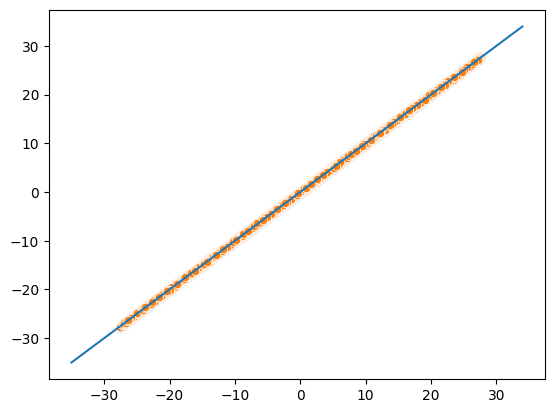

In [14]:
import seaborn as sns
sns.scatterplot(x = Macro_State[0, :], y = Macro_State[2, :])
sns.scatterplot(x = Macro_State[1, :], y = Macro_State[3, :])
sns.lineplot(x = range(-35, 35), y = range(-35, 35))

In [103]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [104]:
pearson_position = pearsonr(Macro_State[0, :], Macro_State[2, :])
print(pearson_position)
pearson_velocity = pearsonr(Macro_State[1, :], Macro_State[3, :])
print(pearson_velocity)
MSE_position = mean_squared_error(Macro_State[0, :], Macro_State[2, :])
print(MSE_position)
MSE_velocity = mean_squared_error(Macro_State[1, :], Macro_State[3, :])
print(MSE_velocity)

PearsonRResult(statistic=0.9999663397816791, pvalue=0.0)
PearsonRResult(statistic=0.9999752155584369, pvalue=0.0)
0.012691560412148957
0.006826203912327361


<Axes: >

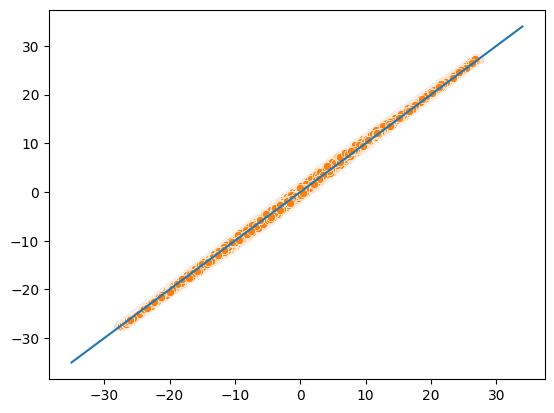

In [15]:
sns.scatterplot(x = y_out[:, 2], y = Macro_actual[0, :])
sns.scatterplot(x = y_out[:, 3], y = Macro_actual[1, :])
sns.lineplot(x = range(-35, 35), y = range(-35, 35))

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

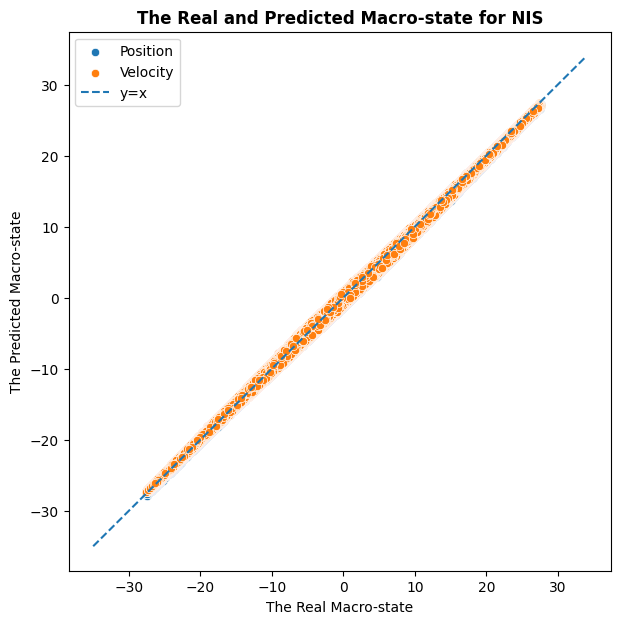

In [17]:
plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.set_title('The Real and Predicted Macro-state for NIS', fontweight='bold', fontsize='12')
ax.set_xlabel('The Real Macro-state')
ax.set_ylabel('The Predicted Macro-state')
Macro_plot = sns.scatterplot(x = Macro_actual[0, :], y = y_out[:, 2], legend='full', label='Position')
sns.scatterplot(x = Macro_actual[1, :], y = y_out[:, 3], legend='full', label='Velocity')
sns.lineplot(x = range(-35, 35), y = range(-35, 35), linestyle='--', label='y=x')
plt.legend()

In [19]:
# Macro_plot.get_figure().savefig('Macro_plot.svg')
Macro_plot.get_figure().savefig(r"D:\Desktop\project_vscode\Neural ODE\Macro_plot_Ode.png")

In [20]:
d_position = y_out[:, 2] - y[:, 2]
d_velocity = y_out[:, 3] - y[:, 3]
y2=np.arange(-21, 22)
y2 = -1*y2

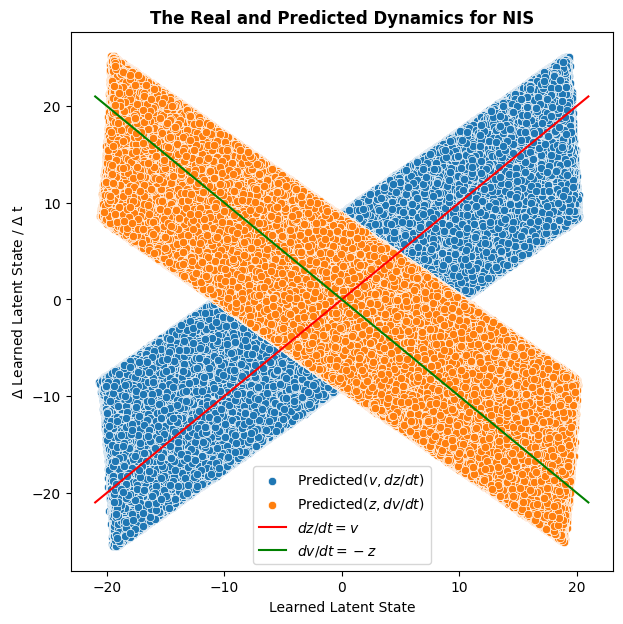

In [21]:
plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.set_title('The Real and Predicted Dynamics for NIS', fontweight='bold', fontsize='12')
ax.set_xlabel('Learned Latent State')
ax.set_ylabel('$\Delta$ Learned Latent State / $\Delta$ t')
Dynamic_plot = sns.scatterplot(x = y[:, 3], y = d_position, legend='full', label='Predicted$(v, dz/dt)$')
sns.scatterplot(x = y[:, 2], y = d_velocity, legend='full', label='Predicted$(z, dv/dt)$')
sns.lineplot(x = range(-21, 22), y = range(-21, 22), linestyle='-', label='$dz/dt=v$', color='red')
sns.lineplot(x = range(-21, 22), y = y2, linestyle='-', label='$dv/dt=-z$', color='green')
plt.legend()

In [22]:
Dynamic_plot.get_figure().savefig(r"D:\Desktop\project_vscode\Neural ODE\Dynamic_plot_Ode.png")

In [23]:
import pandas as pd

<Axes: >

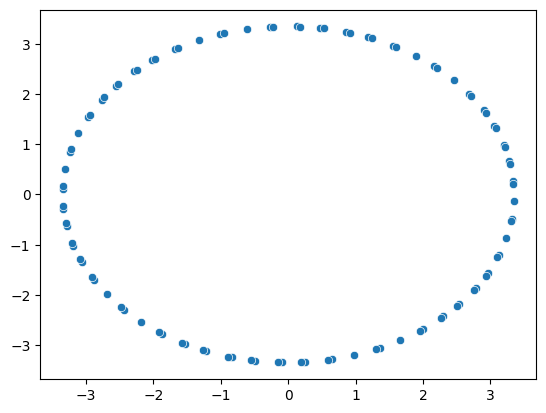

In [24]:
initial_state=np.array([3.82961751,3.295378202,-6.884415995,-9.251218459])
t = np.linspace(0, 100, 100)
actual_state_100 = odeint(SOE, initial_state, t)
Macro_actual_100 = np.array([(actual_state_100[:, 0]+actual_state_100[:,2])/2, (actual_state_100[:, 1]+actual_state_100[:,3])/2])
sns.scatterplot(x=Macro_actual_100[0, :], y=Macro_actual_100[1, :])

<Axes: >

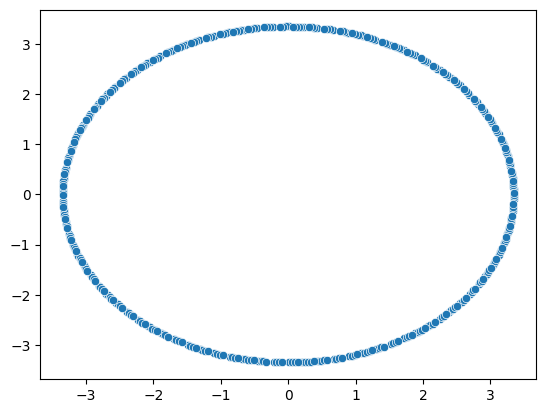

In [61]:
initial_state=np.array([3.82961751,3.295378202,-6.884415995,-9.251218459])
t = np.linspace(0, 401, 401)
actual_state_400 = odeint(SOE, initial_state, t)
df_actual_state_400 = pd.DataFrame(actual_state_400)
# df_actual_state_400.to_csv("actual_state_400.csv")
actual_state_400 = actual_state_400[1: 401, :]
Macro_actual_400 = np.array([(actual_state_400[:, 0]+actual_state_400[:,2])/2, (actual_state_400[:, 1]+actual_state_400[:,3])/2])
sns.scatterplot(x=Macro_actual_400[0, :], y=Macro_actual_400[1, :])

In [46]:
x = initial_state
x = torch.tensor(x)
x_out_list = []
y_out_list = []
for i in range(400):
    x = x.to(device)
    x_out,_,y_out = NIS_ODE(x.float())
    x = x_out

    x_out_list.append(x_out.detach().cpu().numpy())
    y_out_list.append(y_out.detach().cpu().numpy())

    del x_out, y_out

In [55]:
x_out_np = np.concatenate(x_out_list, axis=0)
y_out_np = np.concatenate(y_out_list, axis=0)
predict_400 = np.array([(x_out_np[:, 0]+x_out_np[:, 2])/2, (x_out_np[:, 1]+x_out_np[:, 3])/2])

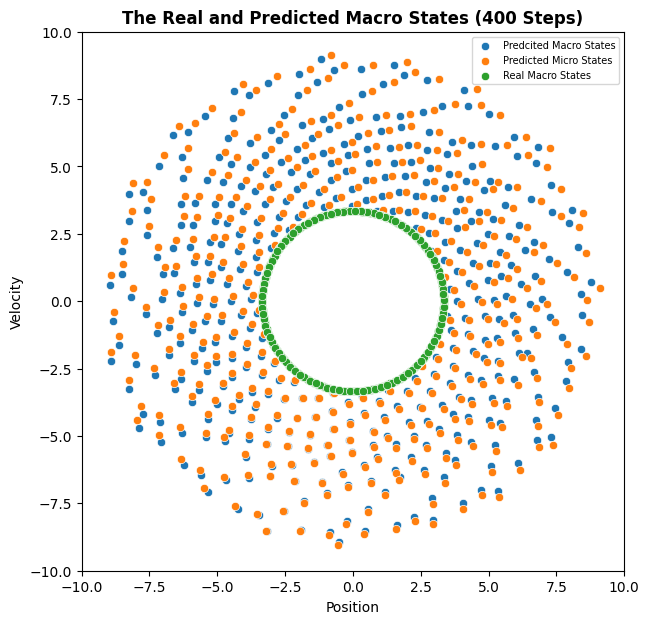

In [95]:
plt.figure(figsize=[7, 7])
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
ax.set_title('The Real and Predicted Macro States (400 Steps)', fontweight='bold', fontsize='12')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
Macro_states_Multi_Steps = sns.scatterplot(x=y_out_np[:, 2], y=y_out_np[:, 3], legend='full', label= 'Predcited Macro States')
sns.scatterplot(x=predict_400[0, :], y=predict_400[1, :], legend='full', label= 'Predicted Micro States')
sns.scatterplot(x=Macro_actual_400[0, :], y=Macro_actual_400[1, :], legend='full', label='Real Macro States')
plt.legend(loc="upper right", prop={'size': 7})


In [96]:
Macro_states_Multi_Steps.get_figure().savefig(r"D:\Desktop\project_vscode\Neural ODE\Ode_400steps(1).png")
# Macro_states_Multi_Steps.get_figure().savefig(r"D:\Desktop\project_vscode\Neural ODE\Ode_400steps(1).png")

In [97]:
import imageio
import os


gif_filename = 'Ode_400_steps.gif'

# 用于存储帧的列表
frames = []

# 动图的帧数
num_frames = 400

# 创建图形对象
for i in range(1, num_frames + 1):
    fig = plt.figure(figsize=[7, 7])
    gs = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs[0, 0])
    ax.set_title('The Real and Predicted Macro States (400 Steps)', fontweight='bold', fontsize='12')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    # 绘制当前帧的散点图
    sns.scatterplot(x=y_out_np[:i, 2], y=y_out_np[:i, 3], legend='full', label='Predicted Macro States', ax=ax)
    sns.scatterplot(x=predict_400[0, :i], y=predict_400[1, :i], legend='full', label='Predicted Micro States', ax=ax)
    sns.scatterplot(x=Macro_actual_400[0, :i], y=Macro_actual_400[1, :i], legend='full', label='Real Macro States', ax=ax)
    plt.legend(loc="upper right", prop={'size': 7})
    # 存储当前帧
    temp_filename = f'temp_frame_{i}.png'
    # plt.savefig(temp_filename, bbox_inches='tight', dpi=300)
    plt.savefig(temp_filename)
    frames.append(imageio.imread(temp_filename))
    plt.close()

print(len(frames), len(gif_filename))
# 创建 GIF 动画
imageio.mimsave(gif_filename, frames, fps=10)


C:\Users\admin\AppData\Local\Temp\ipykernel_13832\2129974239.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_filename))
C:\Users\admin\AppData\Local\Temp\ipykernel_13832\2129974239.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_filename))
C:\Users\admin\AppData\Local\Temp\ipykernel_13832\2129974239.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as im

400 17


In [98]:
# 删除临时文件
for temp_filename in [f'temp_frame_{i}.png' for i in range(1, num_frames + 1)]:
    os.remove(temp_filename)